In [1]:
import pandas as pd
import numpy as np
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

%load_ext autoreload
%autoreload 2
%load_ext lab_black

PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla/20191205_10XVisium_MouseBrainSerial1SA_giovanni.palla"

Read in data

In [2]:
adata = sc.read_visium(
    PATH, count_file="V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In `adata.uns` we store the png images, as well as scalefactors and other metdata

In [3]:
spatial_data = adata.uns["spatial"]["V1_Mouse_Brain_Sagittal_Anterior"]
spatial_data

{'images': {'hires': array([[[0.7254902 , 0.7411765 , 0.73333335],
          [0.72156864, 0.7411765 , 0.7294118 ],
          [0.72156864, 0.7372549 , 0.7294118 ],
          ...,
          [0.7294118 , 0.7490196 , 0.7411765 ],
          [0.7294118 , 0.74509805, 0.7372549 ],
          [0.73333335, 0.7490196 , 0.7411765 ]],
  
         [[0.7254902 , 0.7411765 , 0.73333335],
          [0.72156864, 0.7372549 , 0.73333335],
          [0.72156864, 0.7372549 , 0.7294118 ],
          ...,
          [0.73333335, 0.7490196 , 0.7372549 ],
          [0.73333335, 0.7490196 , 0.7372549 ],
          [0.7254902 , 0.74509805, 0.7372549 ]],
  
         [[0.72156864, 0.7411765 , 0.7294118 ],
          [0.72156864, 0.7411765 , 0.73333335],
          [0.7254902 , 0.7372549 , 0.7294118 ],
          ...,
          [0.7294118 , 0.74509805, 0.7372549 ],
          [0.7254902 , 0.74509805, 0.73333335],
          [0.73333335, 0.7490196 , 0.7372549 ]],
  
         ...,
  
         [[0.72156864, 0.7411765 , 0.737254

Let's load the detected tissue image to correctly visualize spots

In [4]:
detected = plt.imread(PATH + "/spatial/detected_tissue_image.jpg")
hires = spatial_data["images"]["hires"]

In [5]:
xcoord = adata.obsm["spatial"][:, 0]
ycoord = adata.obsm["spatial"][:, 1]

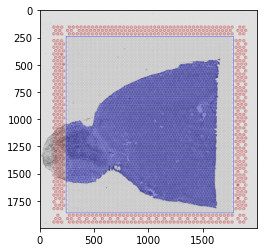

In [6]:
plt.scatter(xcoord, ycoord)
plt.imshow(detected)

You see that real image and spatial coordiantes do not match. We multiply by hires scalefactor

In [7]:
xcoord = np.multiply(
    xcoord,
    spatial_data["scalefactors"]["tissue_hires_scalef"],
)
ycoord = np.multiply(
    ycoord,
    spatial_data["scalefactors"]["tissue_hires_scalef"],
)

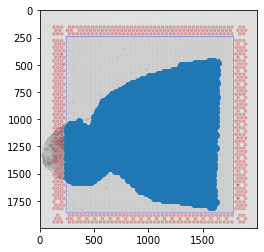

In [8]:
plt.scatter(xcoord, ycoord)
plt.imshow(detected)

Ok, now makes sense. We are still missing the size of the spots though... For this, we need to use another collection (not scatterplot) that allows us to specify the radius.
Code below is copied from [scanpy utils](https://github.com/theislab/scanpy/blob/8611dba1eca98446b9e14c04ba673264a14be4d8/scanpy/plotting/_utils.py#L1083)

In [9]:
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection


def circles(x, y, s, ax, marker=None, c="b", vmin=None, vmax=None, **kwargs):
    """"""

    # You can set `facecolor` with an array for each patch,
    # while you can only set `facecolors` with a value for all.

    zipped = np.broadcast(x, y, s)
    patches = [Circle((x_, y_), s_) for x_, y_, s_ in zipped]
    collection = PatchCollection(patches, **kwargs)
    if isinstance(c, np.ndarray) and np.issubdtype(c.dtype, np.number):
        collection.set_array(c)
        collection.set_clim(vmin, vmax)
    else:
        collection.set_facecolor(c)

    ax.add_collection(collection)

    return collection

In [10]:
# scale_spot set to 1 in this case. In fact, we want the original size, so to have a perfect overlap with the physical spots in the visum array
# the 0.5 scale is used to half diamter to get radius
scale_spot = 1
spot_size = (
    (
        spatial_data["scalefactors"]["tissue_hires_scalef"]
        * spatial_data["scalefactors"]["spot_diameter_fullres"]
    )
    * 0.5
    * scale_spot
)

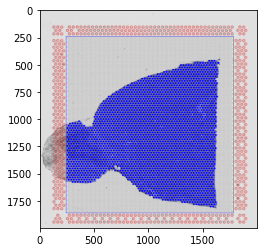

In [11]:
fig, ax = plt.subplots()
circles(xcoord, ycoord, s=spot_size, ax=ax)
plt.imshow(
    detected,
)

looks better, but we need to zoom in in order to appreciate how the size fits with the physical spots in visium array

In [12]:
# Coordinates to use for cropping the image (left, right, top, bottom)
img = detected
crop_coord = np.asarray([300, 500, 1000, 900])

img_coord = (
    *crop_coord[:2],
    *np.ceil(img.shape[0] - crop_coord[2:4]).astype(int),
)

(1098.0, 998.0)

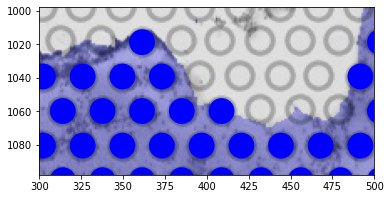

In [13]:
fig, ax = plt.subplots()
circles(xcoord, ycoord, s=spot_size, ax=ax)
plt.imshow(
    detected,
)
ax.set_xlim(img_coord[0], img_coord[1])
ax.set_ylim(img_coord[3], img_coord[2])

That's it! Perfect overlap!

Ok so what about the big tiff image (very high res)?

In [14]:
tif = imageio.imread(PATH + "/V1_Mouse_Brain_Sagittal_Anterior_image.tif")

In [15]:
xcoord = adata.obsm["spatial"][:, 0]
ycoord = adata.obsm["spatial"][:, 1]

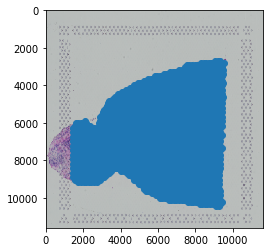

In [16]:
plt.scatter(xcoord, ycoord)
plt.imshow(tif)

you see that actually the coords are in the correct scaling already for this image. Let's get radius and zoom

In [17]:
spot_size = spatial_data["scalefactors"]["spot_diameter_fullres"] * 0.5

In [18]:
img = tif
crop_coord = np.asarray([2000, 2300, 7000, 7500])

img_coord = (
    *crop_coord[:2],
    *np.ceil(img.shape[0] - crop_coord[2:4]).astype(int),
)

(4107.0, 4607.0)

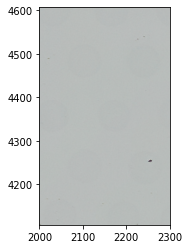

In [19]:
fig, ax = plt.subplots()
circles(xcoord, ycoord, s=spot_size, ax=ax)
plt.imshow(tif)
ax.set_xlim(img_coord[0], img_coord[1])
ax.set_ylim(img_coord[3], img_coord[2])

this was a wrong plot, but I think you can appreciate that the spots are still visible with very low contrast

In [20]:
img = tif
crop_coord = np.asarray([6000, 6300, 7000, 7500])

img_coord = (
    *crop_coord[:2],
    *np.ceil(img.shape[0] - crop_coord[2:4]).astype(int),
)

(4107.0, 4607.0)

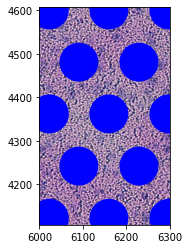

In [21]:
fig, ax = plt.subplots()
circles(xcoord, ycoord, s=spot_size, ax=ax)
plt.imshow(tif)
ax.set_xlim(img_coord[0], img_coord[1])
ax.set_ylim(img_coord[3], img_coord[2])

That's it!
Last small thing to point out is that the coordinate origin is top left, as per image convention.